In [1]:
import numpy as np
import matplotlib.pyplot as plt
%config Completer.use_jedi=False

An information filter is used to combine a noisy measurement and a noisy predicition about the state of a system into a better estimate of the real state of said system

In [2]:
# Lets define some constants so we can play with the simulations later
# I used 81 time steps so at each time step the speed will increase by 1
TIME_STEPS = 81
V_0 = 40
V_F = 120

In [3]:
# Create the true speeds from V_0 to V_F
real_speeds = np.linspace(start=V_0, stop=V_F, num=TIME_STEPS)
# Define a generator that will add a random gaussian noise to the measurements
def speeds():
    for s in real_speeds:
        yield s + np.random.normal(loc=0, scale=3)
print(real_speeds)

[ 40.  41.  42.  43.  44.  45.  46.  47.  48.  49.  50.  51.  52.  53.
  54.  55.  56.  57.  58.  59.  60.  61.  62.  63.  64.  65.  66.  67.
  68.  69.  70.  71.  72.  73.  74.  75.  76.  77.  78.  79.  80.  81.
  82.  83.  84.  85.  86.  87.  88.  89.  90.  91.  92.  93.  94.  95.
  96.  97.  98.  99. 100. 101. 102. 103. 104. 105. 106. 107. 108. 109.
 110. 111. 112. 113. 114. 115. 116. 117. 118. 119. 120.]


On of the most basic forms of information filter is the H-filter, it uses a parameter $h$ to adjust our prediction of the current state of the system by using the residual $ r = Z(t) - P_t$ where $Z(t)$ is the measured state at time $t$ and $P_t$ is the predicted state at time $t$

$h$ measures how much we trust our measurement, if it is 1 our estimate becomes $$\hat x_t = P_t + 1 (Z(t) - P_t) = Z(t)$$

If it $h=0$ on the other hand, we have $$ \hat x_t= P_t - 0(Z(t) - P_t) = P_t$$

In [4]:
def h_filter(initial_estimate, change_rate, measurements, h, time_step=1):
    estimates = [initial_estimate]
    predictions = []
    measured = []
    for z in measurements:
        measured.append(z)
        
        prediction = estimates[-1] + change_rate * time_step
        predictions.append(prediction)
        
        residual = z - prediction
        
        estimate = prediction + h * residual
        estimates.append(estimate)
    return measured, predictions, estimates

In [5]:
# Let's set some parameters for the simulations, note that we do not have to be acurate on the initial speed
# estimate
initial_speed = 0
accel = 1
factor = .2
Z, P, E = h_filter(initial_speed, accel, speeds(), factor)

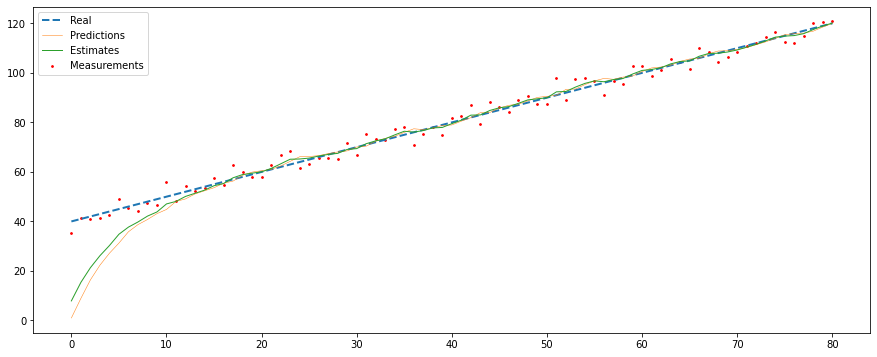

In [6]:
def plot(times, real, Z, P, E):
    fig, ax = plt.subplots(figsize=(15,6))

    ax.plot(times, real, '--', label="Real", linewidth=2)
    ax.scatter(times, Z, label="Measurements", s=3, c = 'red')
    ax.plot(times, P, label="Predictions", linewidth=.5)
    ax.plot(times, E[1:], label="Estimates", linewidth=1)


    ax.legend();

times = np.arange(TIME_STEPS)
plot(times, real_speeds, Z, P, E)

We can see that the estimated speed eventually converges to the real speed, even with the noisy measurements,
the $h$ parameter will dictate how fast it converges, but it will also allor for the measurement noise to filter into the estimations.

Note that we also "guessed" the correct rate of change (the acceleration, in this case), if we guess it wrong the estimates will be biased.

In [7]:
initial_speed = 0
accel = -2 # Guessing a negativa acceleration
factor = .2
Z, P, E = h_filter(initial_speed, accel, speeds(), factor)

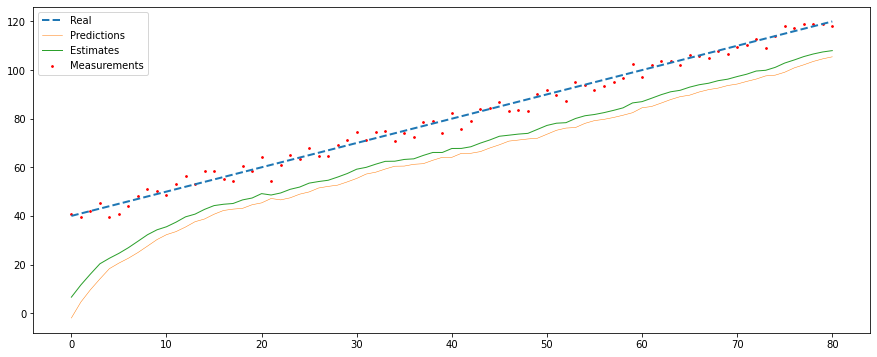

In [8]:
def plot(times, real, Z, P, E):
    fig, ax = plt.subplots(figsize=(15,6))

    ax.plot(times, real, '--', label="Real", linewidth=2)
    ax.scatter(times, Z, label="Measurements", s=3, c = 'red')
    ax.plot(times, P, label="Predictions", linewidth=.5)
    ax.plot(times, E[1:], label="Estimates", linewidth=1)


    ax.legend();

times = np.arange(TIME_STEPS)
plot(times, real_speeds, Z, P, E)

Even with the negative acceleration the estimated speed is increasing with each iteration, although it is biased. We can see the estimate curve is really close to the predictions, which are off because we guessed the wrong rate of change, we can fix this by increasing $h$ and telling the filter that we would rather trust the measurements than the prediction, but this will let sensor noise pollute the estimates.

Having to correctly guess the rate of change is a problem since it may not be easy to do, to fix that we can adjust our rate of change much like in the way we adjust our predictions, the residual $r_t = Z(t) - P_t$ tells us by how much our prediction is off from the measurement, if we then increase our rate of change by that amount we should correct prediction for the next iteration, of course, since $Z(t)$ is noisy, we also add a parameter - $g$ - to tell the filter how much of this information we want to incorporate in the rate of change, this is knonw as th GH-Filter (or sometimes, the $\alpha\beta$-filter)

In [9]:
def gh_filter(initial_estimate, change_rate, measurements, h, g, time_step=1):
    estimates = [initial_estimate]
    predictions = []
    measured = []
    for z in measurements:
        measured.append(z)
        
        prediction = estimates[-1] + change_rate * time_step
        predictions.append(prediction)
        
        residual = z - prediction
        
        estimate = prediction + h * residual
        estimates.append(estimate)
        
        change_rate = change_rate + g * residual/time_step
    return measured, predictions, estimates

We can wirte down the equations for each step of the filter, we have the inital guesses
$$\hat x_0 = \epsilon; \delta x_0 = \delta$$

The prediction is a function of the estimated state, its rate of change and some time step for scaling if needed

$$ P_t = P(\hat x_{t-1}, \delta x_{t-1}, \delta t) $$

We can then compute the residual by subtracting our prediction from the measured state
$$ r_t = Z(t) - P_t$$

Now we allow some of the information from the residual to be incorporated into the prediction, producing the final estimate
$$ E_t = P_t + h r_t $$

We also course correct our rate of change for the next step
$$ \delta x_{t} = \delta x_{t-1} + g \frac{r_t}{\delta t} $$

In [10]:
# Here we have a wrong initial guess and a inital rate of change that is way off, see how the filter qucikly corrects
# the rate of change so it can start tracking the true speed
initial_speed = 0
accel = -50
h = .6
g = .2
Z, P, E = gh_filter(initial_speed, accel, speeds(), h, g)

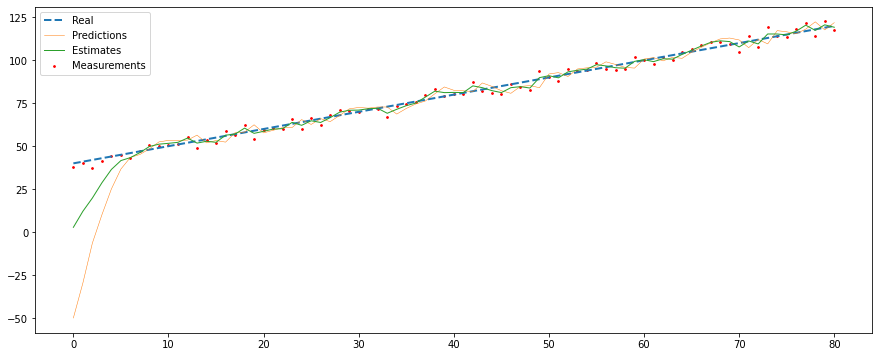

In [11]:
times = np.arange(TIME_STEPS)
plot(times, real_speeds, Z, P, E)

We can see that even with a really poor guess for the rate of change, the filter converged quickly to the real value